In [ ]:
!pip install geopandas shapely rtree folium

Imported Necessary libraries

# Task 1

**Loaded Neighborhood Data**\
I started by loading a dataset containing neighborhood boundaries from a CSV file. The geometries were stored as WKT (Well-Known Text), so I converted them into shapely geometry objects and created a GeoDataFrame with the coordinate system set to EPSG:4326.

**Prepared the Crime Data** \
Then, I loaded the 2025 crime dataset. I cleaned it by dropping rows with missing latitude or longitude values. After that, I converted each valid crime location into a Point geometry and created a GeoDataFrame using the same CRS (EPSG:4326).

**Mapped Crimes to Neighborhoods**\
I performed a spatial join to map each crime to the neighborhood it occurred in. Using the within predicate, I matched crime points to the neighborhood polygons that contained them.

**Saved the Result**
Finally, I selected important columns—like the crime type, location, and matched neighborhood name—and saved the result into a new CSV file named neighborhood_2025.csv.

In [16]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point

In [17]:
neighborhoods_df = pd.read_csv("Neighborhoods_2012b_20250330.csv")
crimes_df = pd.read_csv("Crimes_2025.csv")

In [18]:
neighborhoods_df['geometry'] = neighborhoods_df['the_geom'].apply(wkt.loads)
neighborhoods_gdf = gpd.GeoDataFrame(neighborhoods_df, geometry='geometry', crs='EPSG:4326')

In [19]:
crimes_df = crimes_df.dropna(subset=['Latitude', 'Longitude'])
crimes_gdf = gpd.GeoDataFrame(
    crimes_df,
    geometry=[Point(xy) for xy in zip(crimes_df.Longitude, crimes_df.Latitude)],
    crs='EPSG:4326'
)

In [20]:
result = gpd.sjoin(crimes_gdf, neighborhoods_gdf, how='left', predicate='within')

output_df = result[['ID', 'Date', 'Primary Type', 'Latitude', 'Longitude', 'index_right', 'PRI_NEIGH']]
output_df.to_csv("neighborhood_2025.csv", index=False)

In [21]:
output_df.head(10)

,ID,Date,Primary Type,Latitude,Longitude,index_right,PRI_NEIGH
0,13762411,03/01/2025 12:00:00 AM,OTHER OFFENSE,41.780715,-87.671516,19.0,Englewood
1,13762750,03/01/2025 12:00:00 AM,THEFT,41.924159,-87.699400,13.0,Logan Square
2,13763214,03/01/2025 12:00:00 AM,CRIMINAL DAMAGE,41.779153,-87.654491,19.0,Englewood
3,13774510,03/01/2025 12:00:00 AM,OFFENSE INVOLVING CHILDREN,41.765783,-87.572583,59.0,South Shore
4,13762233,03/01/2025 12:00:00 AM,MOTOR VEHICLE THEFT,41.742318,-87.556371,61.0,South Chicago
5,13762488,03/01/2025 12:00:00 AM,BATTERY,41.721191,-87.616545,62.0,Roseland
6,13765759,03/01/2025 12:00:00 AM,MOTOR VEHICLE THEFT,41.658523,-87.545899,29.0,Hegewisch
7,13787012,03/01/2025 12:00:00 AM,OFFENSE INVOLVING CHILDREN,41.968373,-87.725603,52.0,Albany Park
8,13778866,03/01/2025 12:00:00 AM,OTHER OFFENSE,41.761635,-87.563637,59.0,South Shore
9,13762346,03/01/2025 12:00:00 AM,CRIMINAL DAMAGE,41.764042,-87.695462,69.0,Chicago Lawn


In [22]:
output_df['NEIGHBORHOOD_ID'] = output_df['PRI_NEIGH'].astype('category').cat.codes

<ipython-input-22-3910f7c61f9f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['NEIGHBORHOOD_ID'] = output_df['PRI_NEIGH'].astype('category').cat.codes


# Task 2

**Created an Interactive Crime Map**\
I used Folium to build an interactive map centered on Chicago. I added a choropleth layer using a GeoJSON file that visualizes the number of crimes per neighborhood in varying shades of red and yellow (YlOrRd color scale). This makes it easy to spot neighborhoods with higher or lower crime levels at a glance.

Additionally, I included a tooltip layer so users can hover over each neighborhood and instantly see the name (PRI_NEIGH) and the number of crimes (crime_count) for that area.

**Exported the Map**\
I saved the final interactive map as an HTML file named crime_map_folium_2025.html, which can be opened in any web browser for easy sharing and exploration.



In [23]:
neighborhoods_gdf['NEIGHBORHOOD_ID'] = neighborhoods_gdf['PRI_NEIGH'].astype('category').cat.codes
crime_counts = output_df.groupby("NEIGHBORHOOD_ID").size().reset_index(name="crime_count")
neighborhoods_gdf = neighborhoods_gdf.merge(crime_counts, on="NEIGHBORHOOD_ID", how="left")
neighborhoods_gdf["crime_count"] = neighborhoods_gdf["crime_count"].fillna(0)

In [24]:
import folium

In [25]:
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

folium.Choropleth(
    geo_data=neighborhoods_gdf,
    name="Crime by Neighborhood",
    data=neighborhoods_gdf,
    columns=["NEIGHBORHOOD_ID", "crime_count"],
    key_on="feature.properties.NEIGHBORHOOD_ID",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.4,
    legend_name="Number of Crimes (2025)"
).add_to(m)

folium.GeoJson(
    neighborhoods_gdf,
    tooltip=folium.GeoJsonTooltip(fields=["PRI_NEIGH", "crime_count"],
                                   aliases=["Neighborhood", "Crimes"]),
    name="Labels"
).add_to(m)

m.save("Neighborhood_map_visualization.html")


# Task 3

**Calculated Neighborhood Centroids**\
I grouped the crime data by neighborhood (PRI_NEIGH) and calculated the average latitude and longitude for each one. These serve as approximate centroids representing where crimes are clustered within each neighborhood.

**Projected to Cartesian Coordinates (UTM)**\
To use distance-based methods like KNN properly, I converted geographic coordinates (lat/lon) to Cartesian coordinates using the UTM Zone 16 projection (which covers Chicago). This avoids distortion in distance calculations.

**Applied K-Nearest Neighbors**\
Using sklearn’s NearestNeighbors, I computed the 5 nearest neighbors for each neighborhood based on their UTM coordinates. This helped identify spatially close neighborhoods.

**Built a Mutual Neighbor Graph**\
I constructed a mutual k-nearest neighbor graph using networkx. I only added an edge between two neighborhoods if they both appeared in each other’s top 5 neighbors — ensuring the relationship is mutual. Nodes represent neighborhoods, and edges represent strong spatial proximity.

**Plotted the Network (Static)**\
Finally, I plotted the network graph using matplotlib, showing how Chicago’s neighborhoods are spatially connected based on their crime centroids. Each node is labeled and positioned accurately based on its projected coordinates.



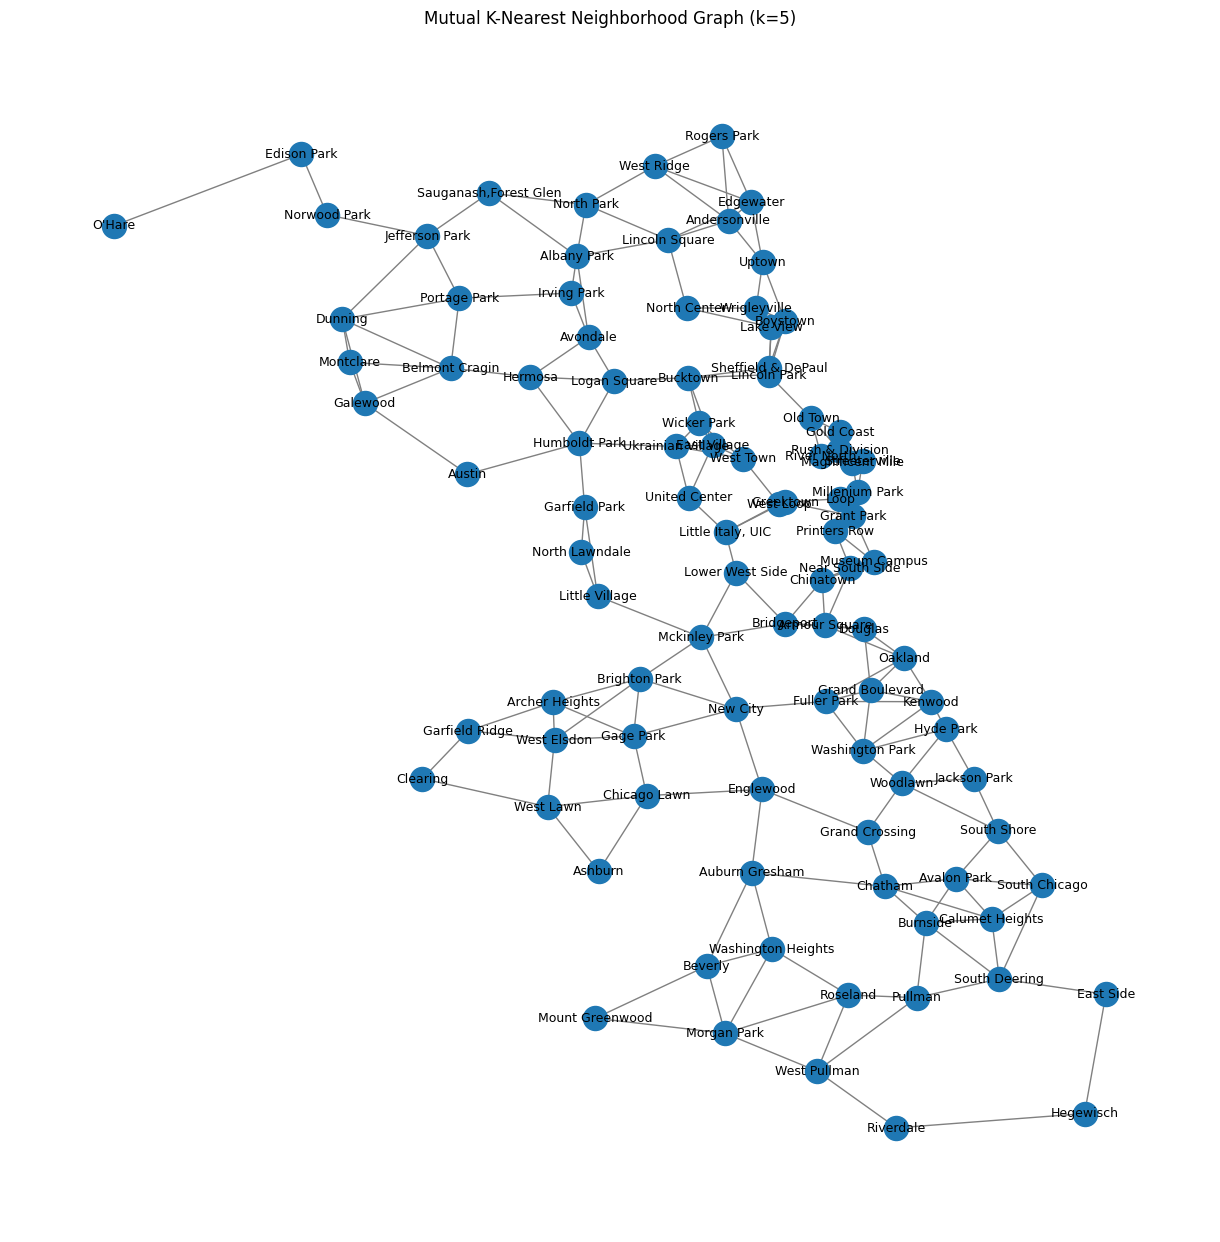

In [26]:
import matplotlib.pyplot as plt
import networkx as nx
from pyproj import Proj
from sklearn.neighbors import NearestNeighbors
import folium
from shapely.geometry import LineString

crime_neighborhood_df = pd.read_csv("neighborhood_2025.csv")

centroids = crime_neighborhood_df.groupby('PRI_NEIGH').agg(
    Longitude=('Longitude', 'mean'),
    Latitude=('Latitude', 'mean')
).reset_index()

proj = Proj(proj="utm", zone=16, datum="WGS84")
centroids['x'], centroids['y'] = zip(*[proj(lon, lat) for lon, lat in zip(centroids['Longitude'], centroids['Latitude'])])

coords = centroids[['x', 'y']].values
knn = NearestNeighbors(n_neighbors=6)
knn.fit(coords)
distances, indices = knn.kneighbors(coords)

G = nx.Graph()
id_to_name = dict(enumerate(centroids['PRI_NEIGH']))

for i, row in centroids.iterrows():
    G.add_node(row['PRI_NEIGH'], pos=(row['x'], row['y']), lat=row['Latitude'], lon=row['Longitude'])

edges = set()
for i, neighbors in enumerate(indices):
    for j in neighbors[1:]:
        if i in indices[j][1:]:
            a, b = id_to_name[i], id_to_name[j]
            edges.add(tuple(sorted((a, b))))

G.add_edges_from(edges)

plt.figure(figsize=(12, 12))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=300, font_size=9, edge_color='gray')
plt.title("Mutual K-Nearest Neighborhood Graph (k=5)")
plt.show()


**Built an Interactive Map with Graph Overlay**\
I created an interactive Folium map centered on Chicago to visualize the mutual k-nearest neighbor graph I constructed earlier.

I added graph edges as blue lines between neighborhood centroids, showing spatial relationships between mutually close neighborhoods. These lines represent strong proximity-based connections based on crime centroids.

Then, I added each neighborhood centroid as a black circle marker, giving users a clear visual reference for where each node (neighborhood) is located geographically.

Finally, I saved the map as knn_graph_overlay_map.html, making it easy to explore in any browser and great for presentations or stakeholder demos.


In [27]:

m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

for edge in G.edges():
    a, b = edge
    a_lat, a_lon = G.nodes[a]['lat'], G.nodes[a]['lon']
    b_lat, b_lon = G.nodes[b]['lat'], G.nodes[b]['lon']

    folium.PolyLine(
        locations=[(a_lat, a_lon), (b_lat, b_lon)],
        color='blue', weight=1, opacity=0.5
    ).add_to(m)

for node in G.nodes():
    lat, lon = G.nodes[node]['lat'], G.nodes[node]['lon']
    folium.CircleMarker(location=(lat, lon), radius=3, color='black', fill=True).add_to(m)

m.save("Crimes_layout_Visualization.html")